In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import seaborn as sns



In [8]:

def add_basicfeatures(df):
    ret1 = df['Close'].pct_change()
    ma5 = df['Close'].rolling(5).mean()
    ma20 = df['Close'].rolling(20).mean()
    ma_diff = ma5 - ma20
    vol_20 = ret1.rolling(20).std()
    return ret1, ma5, ma20, ma_diff, vol_20

def add_ema(df):
    ema_fast = df['Close'].ewm(span=12, adjust=False).mean()
    ema_slow = df['Close'].ewm(span=26, adjust=False).mean()
    ema_cross = ema_fast - ema_slow
    return ema_fast, ema_slow, ema_cross

def add_macd(df):
    ema_fast, ema_slow, _ = add_ema(df)
    macd = ema_fast - ema_slow
    macd_signal = macd.ewm(span=9, adjust=False).mean()
    macd_hist = macd - macd_signal
    return macd, macd_signal, macd_hist

def add_ichimoku(df):
    period9_high = df['High'].rolling(window=9).max()
    period9_low = df['Low'].rolling(window=9).min()
    tenkan = (period9_high + period9_low) / 2

    period26_high = df['High'].rolling(window=26).max()
    period26_low = df['Low'].rolling(window=26).min()
    kijun = (period26_high + period26_low) / 2

    senkou_a = ((tenkan + kijun) / 2).shift(26)
    period52_high = df['High'].rolling(window=52).max()
    period52_low = df['Low'].rolling(window=52).min()
    senkou_b = ((period52_high + period52_low) / 2).shift(26)

    chikou = df['Close'].shift(-26)
    cloud_thickness = (senkou_a - senkou_b).abs()
    close_above_cloud = (df['Close'] > pd.concat([senkou_a, senkou_b], axis=1).max(axis=1)).astype(int)
    tenkan_above_kijun = (tenkan > kijun).astype(int)

    return tenkan, kijun, senkou_a, senkou_b, chikou, cloud_thickness, close_above_cloud, tenkan_above_kijun

def add_ATR(df, period=14):
    H_L = df['High'] - df['Low']
    H_PC = (df['High'] - df['Close'].shift(1)).abs()
    L_PC = (df['Low'] - df['Close'].shift(1)).abs()
    TR = pd.concat([H_L, H_PC, L_PC], axis=1).max(axis=1)
    ATR = TR.rolling(window=period).mean()
    return ATR

def add_RSI(df, period=14):
    delta = df['Close'].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def add_stochastic(df, k_period=14, d_period=3):
    low_min = df['Low'].rolling(window=k_period).min()
    high_max = df['High'].rolling(window=k_period).max()
    stochastic_k = 100 * ((df['Close'] - low_min) / (high_max - low_min))
    stochastic_d = stochastic_k.rolling(window=d_period).mean()
    return stochastic_k, stochastic_d

def add_obv(df):
    delta = df['Close'].diff()
    direction = delta.apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
    obv = (direction * df['Volume']).cumsum()
    return obv

def add_ROC(df, period=12):
    prev_close = df['Close'].shift(period)
    roc = ((df['Close'] - prev_close) / prev_close) * 100
    return roc

def add_price_action(df):
    candle_body = df['Close'] - df['Open']
    candle_range = df['High'] - df['Low']
    upper_shadow = df['High'] - df[['Close', 'Open']].max(axis=1)
    lower_shadow = df[['Close', 'Open']].min(axis=1) - df['Low']
    body_to_range = candle_body.abs() / (candle_range + 1e-9)
    upper_to_lower_shadow = upper_shadow / (lower_shadow + 1e-9)
    direction = (df['Close'] > df['Open']).astype(int)

    return (candle_body, candle_range, upper_shadow, lower_shadow,
            body_to_range, upper_to_lower_shadow, direction)

def add_bollinger(df, period=20):
    ma = df['Close'].rolling(period).mean()
    std = df['Close'].rolling(period).std()
    bb_upper = ma + 2 * std
    bb_lower = ma - 2 * std
    bb_width = bb_upper - bb_lower
    bb_percent = (df['Close'] - bb_lower) / (bb_upper - bb_lower + 1e-9)
    return bb_upper, bb_lower, bb_width, bb_percent


def add_mfi(df, period=14):
    typical_price = (df['High'] + df['Low'] + df['Close']) / 3
    money_flow = typical_price * df['Volume']
    pos_flow = money_flow.where(typical_price > typical_price.shift(1), 0)
    neg_flow = money_flow.where(typical_price < typical_price.shift(1), 0)
    pos_sum = pos_flow.rolling(period).sum()
    neg_sum = neg_flow.rolling(period).sum()
    mfi = 100 * (pos_sum / (pos_sum + neg_sum + 1e-9))
    return mfi

def add_williams_r(df, period=14):
    highest_high = df['High'].rolling(period).max()
    lowest_low = df['Low'].rolling(period).min()
    williams_r = -100 * (highest_high - df['Close']) / (highest_high - lowest_low + 1e-9)
    return williams_r


def add_pvt(df):
    pvt = ((df['Close'] - df['Close'].shift(1)) / (df['Close'].shift(1) + 1e-9)) * df['Volume']
    pvt = pvt.cumsum()
    return pvt

def add_rolling_stats(df, window=10):
    roll_mean = df['Close'].rolling(window).mean()
    roll_std = df['Close'].rolling(window).std()
    roll_skew = df['Close'].rolling(window).skew()
    roll_kurt = df['Close'].rolling(window).kurt()
    return roll_mean, roll_std, roll_skew, roll_kurt

def rolling_slope(series, window=5):
    slopes = [np.nan] * len(series)
    for i in range(window, len(series)):
        y = series[i - window:i]
        x = np.arange(window)
        slope = np.polyfit(x, y, 1)[0]
        slopes[i] = slope
    return pd.Series(slopes, index=series.index)

def add_slopes(df):
    slope_5 = rolling_slope(df['Close'], 5)
    slope_20 = rolling_slope(df['Close'], 20)
    return slope_5, slope_20

def add_feature_interactions(df):
    rsi_macd = add_RSI(df) * add_macd(df)[0]
    atr_vol_ratio = add_ATR(df) / (add_basicfeatures(df)[4] + 1e-9)
    ema_diff_ratio = add_ema(df)[0] / (add_ema(df)[1] + 1e-9)
    return rsi_macd, atr_vol_ratio, ema_diff_ratio


def feature_extraction(df):
    ret1, ma5, ma20, ma_diff, vol_20 = add_basicfeatures(df)
    ema_fast, ema_slow, ema_cross = add_ema(df)
    macd, macd_signal, macd_hist = add_macd(df)
    tenkan, kijun, senkou_a, senkou_b, chikou, cloud_thick, close_above_cloud, tenkan_above_kijun = add_ichimoku(df)
    atr = add_ATR(df)
    rsi = add_RSI(df)
    stochastic_k, stochastic_d = add_stochastic(df)
    obv = add_obv(df)
    roc = add_ROC(df)
    candle_body, candle_range, upper_shadow, lower_shadow,body_to_range, upper_to_lower_shadow, direction=add_price_action(df)
    bb_upper, bb_lower, bb_width, bb_percent=add_bollinger(df)
    mfi=add_mfi(df)
    williams_r=add_williams_r(df)
    pvt=add_pvt(df)
    roll_mean, roll_std, roll_skew, roll_kurt=add_rolling_stats(df)
    slope_5, slope_20=add_slopes(df)
    rsi_macd, atr_vol_ratio, ema_diff_ratio=add_feature_interactions(df)

    
    df = df.copy()
    #df['ret1'] = ret1
    #df['ma_5'] = ma5
    #df['ma_20'] = ma20
    #df['ma_diff'] = ma_diff
    df['vol_20'] = vol_20
    #df['ema_fast'] = ema_fast
    #df['ema_slow'] = ema_slow
    #df['ema_cross'] = ema_cross
    df['macd'] = macd
    #df['macd_signal'] = macd_signal
    df['macd_hist'] = macd_hist
    df['tenkan'] = tenkan
    #df['kijun'] = kijun
    #df['senkou_a'] = senkou_a
    #df['senkou_b'] = senkou_b
    #df['chikou'] = chikou
    df['cloud_thick'] = cloud_thick
    df['close_above_cloud'] = close_above_cloud
    df['tenkan_above_kijun'] = tenkan_above_kijun
    df['ATR'] = atr
    #df['rsi'] = rsi
    #df['stochastic_k'] = stochastic_k
    #df['stochastic_d'] = stochastic_d
    df['obv'] = obv
    #df['roc'] = roc
    df["candle_body"]=candle_body
    df["candle_range"]=candle_range
    df["upper_shadow"]=upper_shadow
    df["lower_shadow"]=lower_shadow
    df["body_to_range"]=body_to_range
    df["upper_to_lower_shadow"]=upper_to_lower_shadow
    df["direction"]=direction
    #df["bb_upper"]=bb_upper
    #df["bb_lower"]=bb_lower
    df["bb_width"]=bb_width
    df["bb_percent"]=bb_percent
    df["mfi"]=mfi
    #df["williams_r"]=williams_r
    df["pvt"]=pvt
    #df["roll_mean"]=roll_mean
    df["roll_std"]=roll_std
    df["roll_skew"]=roll_skew
    df["roll_kurt"]=roll_kurt
    df["slope_5"]=slope_5
    #df["slope_20"]=slope_20
    #df["rsi_macd"]=rsi_macd
    df["atr_vol_ratio"]=atr_vol_ratio
    #df["ema_diff_ratio"]=ema_diff_ratio
    
    
    return df

In [75]:
dataset_path = "/kaggle/input/euro-usd1h/cleaned_data_EUROUSD_1H.csv"
dataset_raw = pd.read_csv(dataset_path)
dataset_raw = dataset_raw.dropna(subset=['Close'])
dataset_raw['future_close'] = dataset_raw['Close'].shift(-1)
dataset_raw = dataset_raw.dropna(subset=['future_close'])
dataset_raw['label'] = (dataset_raw['future_close'] > dataset_raw['Close']).astype(int)
#dataset['label'] = ((dataset['future_close'] / dataset['Close'] - 1) > 0.002).astype(int)

dataset = feature_extraction(dataset_raw)
dataset.dropna(axis=0, how='any', inplace=True)

Y=dataset.iloc[:,9]
#X = dataset.drop(columns=['label', 'future_close'])
X=dataset.iloc[:,10:]
print(Y)
#Y = dataset['label']

# Scale features


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)


77       0
78       1
79       1
80       1
81       0
        ..
99994    0
99995    1
99996    0
99997    1
99998    0
Name: label, Length: 99922, dtype: int64


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)


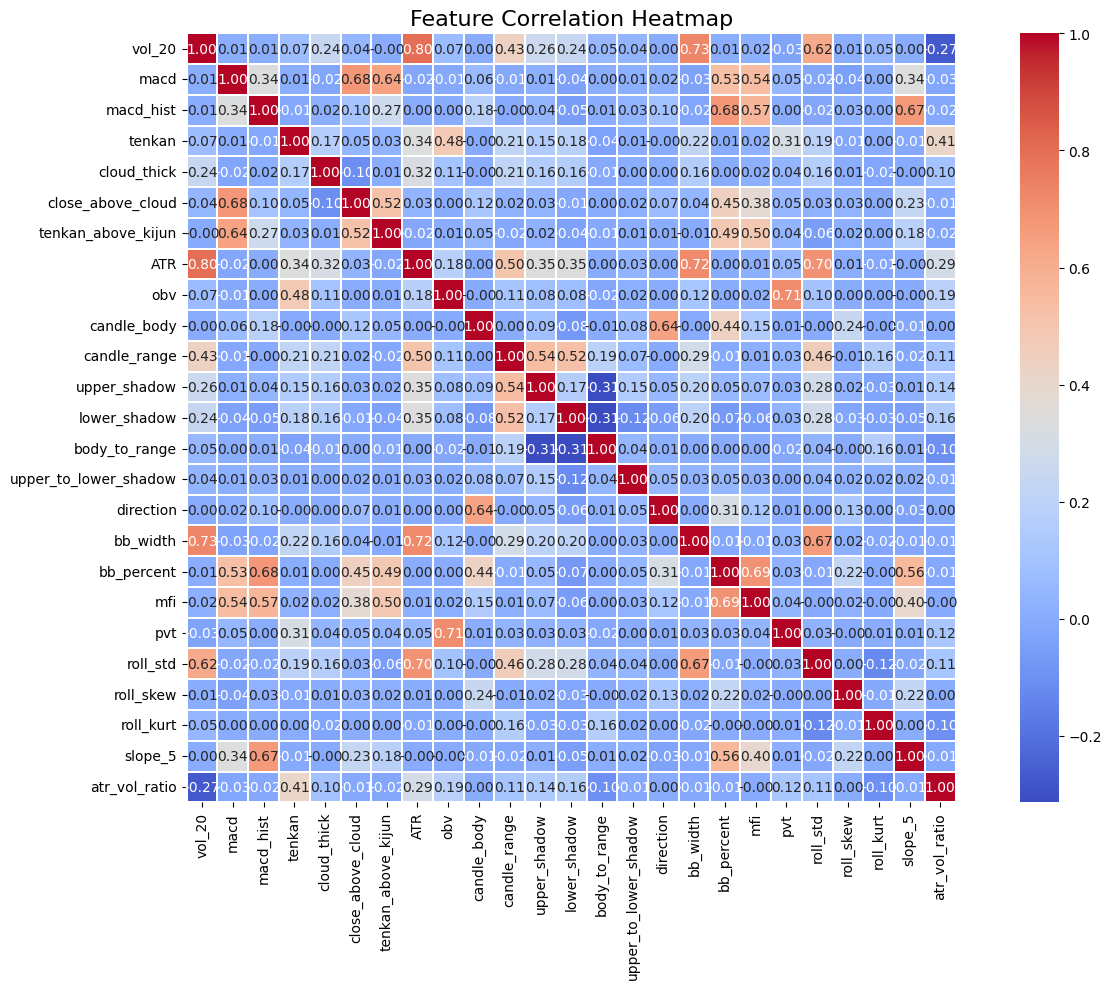

In [76]:
corr_matrix = X.corr()

# Plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, 
            annot=True,        # show correlation values
            fmt=".2f",         # two decimal places
            cmap='coolwarm',   # color scheme
            linewidths=0.1,    # lines between cells
            square=True)

plt.title("Feature Correlation Heatmap", fontsize=16)
plt.tight_layout()
plt.show()

In [77]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.98)
principal_components = pca.fit_transform(X.dropna())

In [78]:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(principal_components)

In [79]:
def create_sequences(X, y, window=30):
    Xs, ys = [], []
    for i in range(window, len(X)):
        Xs.append(X[i-window:i])
        ys.append(y.iloc[i])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, Y, window=10)
print(X_seq.shape)

(99912, 10, 1)


In [80]:
tscv = TimeSeriesSplit(n_splits=5)
fold = 1
accuracy_scores = []

for train_index, val_index in tscv.split(X_seq):
    X_train, X_val = X_seq[train_index], X_seq[val_index]
    y_train, y_val = y_seq[train_index], y_seq[val_index]

    # Step 5: Build CNN-LSTM model
    model = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    Dropout(0.3),

    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.3),

    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
    ])
    callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(patience=5, factor=0.5)]

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history=model.fit(X_train, y_train, validation_data=(X_val, y_val), 
    epochs=10, batch_size=64, callbacks=callbacks)
    
    # Step 7: Evaluate
    y_pred_prob = model.predict(X_val)
    
    # Convert probabilities to class labels (0 or 1)
    y_pred = (y_pred_prob > 0.5).astype(int).squeeze()
    
    # Calculate accuracy
    accuracy = np.mean(y_pred == y_val)
    accuracy_scores.append(accuracy)
    
    print(f"Fold {fold} Accuracy: {accuracy:.4f}")
    fold += 1

print(f"Average Accuracy across folds: {np.mean(accuracy_scores):.4f}")


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.4973 - loss: 0.6957 - val_accuracy: 0.4940 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.4939 - loss: 0.6944 - val_accuracy: 0.5063 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.4995 - loss: 0.6938 - val_accuracy: 0.4917 - val_loss: 0.6945 - learning_rate: 0.0010
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.4904 - loss: 0.6939 - val_accuracy: 0.5067 - val_loss: 0.6933 - learning_rate: 0.0010
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5020 - loss: 0.6935 - val_accuracy: 0.5067 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 6/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5037 - loss: 0.6935 - val_accuracy: 0.4939 - val_loss: 0.6936 - learning_rate: 0.0010
Epoch 7/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.4867 - loss: 0.6935 - val_

521/521 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4994 - loss: 0.6932
Validation Accuracy: 50.01%
521/521 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

           0       0.50      0.63      0.56      8320
           1       0.50      0.37      0.43      8332

    accuracy                           0.50     16652
   macro avg       0.50      0.50      0.49     16652
weighted avg       0.50      0.50      0.49     16652

[[5217 3103]
 [5222 3110]]


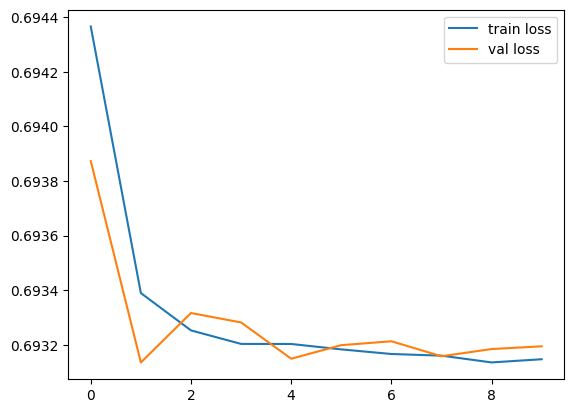

In [81]:
loss, acc = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {acc*100:.2f}%")

y_pred = (model.predict(X_val) > 0.5).astype(int)
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

Use Pytorch Library

In [82]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [83]:
class CNN_LSTM(nn.Module):
    def __init__(self, input_size, seq_len, cnn_filters=32, kernel_size=3,
                 lstm_hidden=64, lstm_layers=1, output_size=1, dropout=0.3):
        super(CNN_LSTM, self).__init__()

        # 1D CNN expects input: (batch, channels, seq_len)
        # We'll use num_features as "channels"
        self.conv1 = nn.Conv1d(
            in_channels=input_size,
            out_channels=cnn_filters,
            kernel_size=kernel_size,
            padding=kernel_size // 2
        )
        self.bn1 = nn.BatchNorm1d(cnn_filters)
        self.relu = nn.ReLU()

        # LSTM expects input: (batch, seq_len, features)
        self.lstm = nn.LSTM(
            input_size=cnn_filters,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True
        )

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(lstm_hidden, output_size)
        self.sigmoid = nn.Sigmoid()  # binary classification

    def forward(self, x):
        # x: (batch, seq_len, features)
        x = x.permute(0, 2, 1)  # → (batch, features, seq_len)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = x.permute(0, 2, 1)  # → (batch, seq_len, cnn_filters)
        out, _ = self.lstm(x)
        out = out[:, -1, :]     # take last time step
        out = self.dropout(out)
        out = self.fc(out)
        out = self.sigmoid(out)
        return out

In [84]:
seq_len = X_seq.shape[1]
num_features = X_seq.shape[2]

# Train/Validation Split
X_train, X_val, y_train, y_val = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42
)

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [85]:
model = CNN_LSTM(input_size=num_features, seq_len=seq_len)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Optional: GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


CNN_LSTM(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (lstm): LSTM(32, 64, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [86]:
epochs = 30
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # ---- Validation ----
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor.to(device))
        val_loss = criterion(val_outputs, y_val_tensor.to(device))
        val_losses.append(val_loss.item())

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss.item():.4f}")


Epoch [1/30] Train Loss: 0.6937 | Val Loss: 0.6932
Epoch [2/30] Train Loss: 0.6933 | Val Loss: 0.6935
Epoch [3/30] Train Loss: 0.6933 | Val Loss: 0.6932
Epoch [4/30] Train Loss: 0.6932 | Val Loss: 0.6932
Epoch [5/30] Train Loss: 0.6932 | Val Loss: 0.6932
Epoch [6/30] Train Loss: 0.6932 | Val Loss: 0.6932
Epoch [7/30] Train Loss: 0.6932 | Val Loss: 0.6932
Epoch [8/30] Train Loss: 0.6932 | Val Loss: 0.6934
Epoch [9/30] Train Loss: 0.6932 | Val Loss: 0.6933
Epoch [10/30] Train Loss: 0.6932 | Val Loss: 0.6933
Epoch [11/30] Train Loss: 0.6932 | Val Loss: 0.6932
Epoch [12/30] Train Loss: 0.6932 | Val Loss: 0.6932
Epoch [13/30] Train Loss: 0.6932 | Val Loss: 0.6932
Epoch [14/30] Train Loss: 0.6932 | Val Loss: 0.6932
Epoch [15/30] Train Loss: 0.6932 | Val Loss: 0.6933
Epoch [16/30] Train Loss: 0.6932 | Val Loss: 0.6933
Epoch [17/30] Train Loss: 0.6932 | Val Loss: 0.6932
Epoch [18/30] Train Loss: 0.6932 | Val Loss: 0.6932
Epoch [19/30] Train Loss: 0.6931 | Val Loss: 0.6933
Epoch [20/30] Train L

In [87]:
model.eval()
with torch.no_grad():
    y_pred_val = model(X_val_tensor.to(device))
    y_pred_class = (y_pred_val > 0.5).float()

y_true = y_val_tensor.cpu().numpy()
y_pred = y_pred_class.cpu().numpy()
print()
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


📊 Classification Report:
              precision    recall  f1-score   support

         0.0       0.50      0.63      0.56     10002
         1.0       0.49      0.36      0.41      9981

    accuracy                           0.49     19983
   macro avg       0.49      0.49      0.48     19983
weighted avg       0.49      0.49      0.48     19983

Confusion Matrix:
[[6324 3678]
 [6420 3561]]


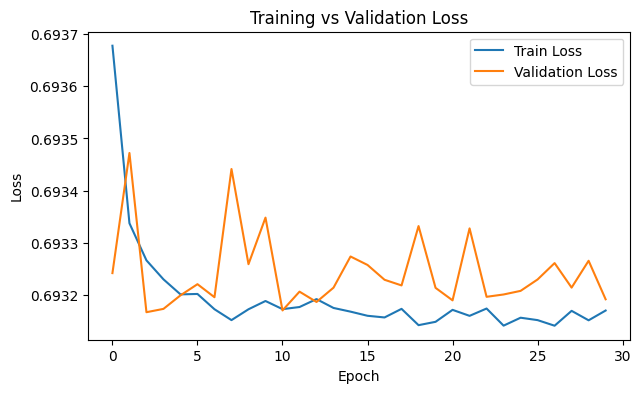

In [88]:
plt.figure(figsize=(7,4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expres

Shape of sequence data: (99912, 10, 1)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 10, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 10, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,505 (146.50 KB)

 Trainable params: 37,505 (146.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.5064 - loss: 0.6935 - val_accuracy: 0.4852 - val_loss: 0.6953
Epoch 2/100
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5010 - loss: 0.6932 - val_accuracy: 0.4852 - val_loss: 0.6938
Epoch 3/100
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5040 - loss: 0.6931 - val_accuracy: 0.4852 - val_loss: 0.6934
Epoch 4/100
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5038 - loss: 0.6931 - val_accuracy: 0.4852 - val_loss: 0.6939
Epoch 5/100
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5011 - loss: 0.6932 - val_accuracy: 0.4852 - val_loss: 0.6940
Epoch 6/100
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5001 - loss: 0.6932 - val_accuracy: 0.4852 - val_loss: 0.6954
Epoch 7/100
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5011 - loss: 0.6930 - val_accuracy: 0.5042 - val_loss: 0.6932
Epoch 8/100
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5015 - loss: 0

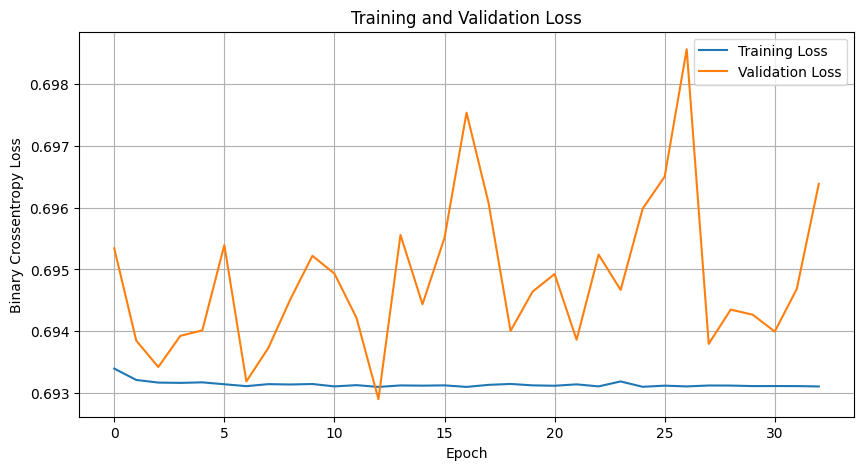

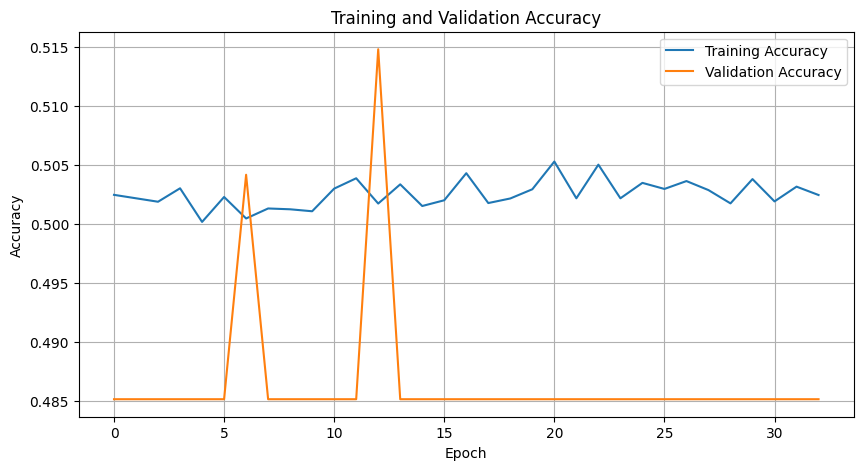

2498/2498 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Feature shape for XGBoost: (79929, 64)
Meta XGBoost accuracy: 0.4979232347495371
              precision    recall  f1-score   support

           0       0.50      0.72      0.59      9989
           1       0.50      0.28      0.35      9994

    accuracy                           0.50     19983
   macro avg       0.50      0.50      0.47     19983
weighted avg       0.50      0.50      0.47     19983



In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
# --- Load your dataset ---
dataset_path = "/kaggle/input/euro-usd1h/cleaned_data_EUROUSD_1H.csv"
dataset_raw = pd.read_csv(dataset_path)
dataset_raw = dataset_raw.dropna(subset=['Close'])
dataset_raw['future_close'] = dataset_raw['Close'].shift(-1)
dataset_raw = dataset_raw.dropna(subset=['future_close'])
dataset_raw['label'] = (dataset_raw['future_close'] > dataset_raw['Close']).astype(int)

# --- Feature extraction (your function) ---
dataset = feature_extraction(dataset_raw)
dataset.dropna(axis=0, how='any', inplace=True)

Y = dataset.iloc[:, 9]             # label
X = dataset.iloc[:, 10:]           # features

# --- PCA + scaling ---
pca = PCA(n_components=0.98)
principal_components = pca.fit_transform(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(principal_components)

# --- Sequence generation ---
def create_sequences(X, y, window=10):
    Xs, ys = [], []
    for i in range(window, len(X)):
        Xs.append(X[i-window:i])
        ys.append(y.iloc[i])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, Y, window=10)
print("Shape of sequence data:", X_seq.shape)

# --- Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42, shuffle=False)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


# --- CNN + LSTM model ---
input_shape = (X_train.shape[1], X_train.shape[2])
inputs = Input(shape=input_shape)
x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.2)(x)
x = LSTM(64, return_sequences=False)(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

cnn_lstm_model = Model(inputs, outputs)
cnn_lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
cnn_lstm_model.summary()

# --- Train the CNN+LSTM ---
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = cnn_lstm_model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=64,
    verbose=1,
    callbacks=[early_stop]
)

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy Loss')
plt.legend()
plt.grid(True)
plt.show()

# --- Plot Training vs Validation Accuracy ---
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# --- Extract deep features from CNN+LSTM ---
feature_extractor = Model(inputs=cnn_lstm_model.input, outputs=cnn_lstm_model.layers[-2].output)
X_train_features = feature_extractor.predict(X_train)
X_test_features = feature_extractor.predict(X_test)

print("Feature shape for XGBoost:", X_train_features.shape)

# --- Train XGBoost meta-learner ---
xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss'
)
xgb_model.fit(X_train_features, y_train)

# --- Evaluate ---
y_pred = xgb_model.predict(X_test_features)
acc = accuracy_score(y_test, y_pred)
print("Meta XGBoost accuracy:", acc)
print(classification_report(y_test, y_pred))
